# SpamDataset_K_Nearest_Neighbor_Classifier
Author: Xin Zhengfang

## Data Preprocessing

In [104]:
import scipy.io as sio
import numpy as np

In [105]:
# Load .mat file into numpy array
mat_contents = sio.loadmat('spamData.mat')
mat_contents.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Xtrain', 'Xtest', 'ytrain', 'ytest'])

In [106]:
#  Convert to arrary
Xtrain = mat_contents['Xtrain']
Xtest = mat_contents['Xtest']
ytrain = mat_contents['ytrain']
ytest = mat_contents['ytest']
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(3065, 57) (1536, 57) (3065, 1) (1536, 1)


In [107]:
# Data preprocessing

# Log-transform
#  normally np.log(data + 1e-7) is more common
log_Xtrain = np.log(Xtrain+1e-7)
log_Xtest = np.log(Xtest+1e-7)

## K Nearest neighbor classifier

1. You define a kind of distance.

2. Measure the distance between the candidate sample with all other training samples

3. Choose k nearest traning samples as voters

5. Vote for the candidate's label.

Above is just my simple peronal understanding.

See the detailed context in Pattern_XINClassification_by_Richard_O._Dud__CHAPTER 4.4

We use L2 distance there:
$$
d(\mathbf{p}, \mathbf{q})=\sqrt{\left(p_{1}-q_{1}\right)^{2}+\left(p_{2}-q_{2}\right)^{2}+\cdots+\left(p_{i}-q_{i}\right)^{2}+\cdots+\left(p_{n}-q_{n}\right)^{2}}=\sqrt{\sum_{i=1}^{n}\left(p_{i}-q_{i}\right)^{2}}
$$
where $p$ $q$ are feature vectors.

We use martix operation to accelate the calculation.
$$
(X_1 - X_2)^2  = X_1^2 + X_2^2 - 2X_1^TX_2
$$
where $X_1$ is $N_1xD$, and $X_2$ is $N_2xD$
This is hard to understand, but it is worthy to spend time on it.

This trick I learned from cs231n

In [108]:
# Training ★
def compute_distances(X1,X2):
    '''
    X1: N1xD
    X2: N2xD Xtrain
    
    dists: N1xN2
    '''
    X1_square = np.repeat(np.sum(X1**2,axis=1,keepdims=True),X2.shape[0],axis=1) # N1xN2
    X2_square = np.repeat(np.sum(X2**2,axis=1,keepdims=True),X1.shape[0],axis=1).T #N1xN2
    A = 2*np.matmul(X1,X2.T) # N1xN2
    dists = X1_square + X2_square - A

    return dists

In [109]:
def pred(X1X2_dists,X2_label,k):
    '''
    X1X2_dists: N1xN2
    X2_label; N2x1
    k: the number of nearest neighbors
    
    pred: N1x1
    '''
    pred = np.zeros(X1X2_dists.shape[0])
    num_pred = X1X2_dists.shape[0]
    for i in range(num_pred):
        closest_label = []
        for n in np.argsort(X1X2_dists[i])[0:k]:
            closest_label.append(X2_label[n].item())
        pred[i] = np.bincount(closest_label).argmax()
    return pred

In [110]:
# Xtrain_pred 
ks = [i for i in range(1,11)] + [i for i in range(15,105,5)]
k_pred_train = []
k_err_train = []
# for each of k
for i in range(len(ks)):
    # There is a bug here, they can vote themself, which is immoral.
    # However, train dataset is actually in my support storage, why not use every point!
    dists = compute_distances(log_Xtrain,log_Xtrain)
    k_pred_train.append(pred(dists,ytrain,ks[i]))
    k_err_train.append(1 - np.sum((k_pred_train[i]==ytrain.reshape(-1)).astype('int'))/ytrain.shape[0])

### Why k = 1 ,  k_err_train != 0 ???
See the debug process below.

In [111]:
a = np.array(k_pred_train[0]==ytrain.reshape(-1))

In [112]:
print(np.where(a==False))
a[1881]

(array([1881], dtype=int64),)


False

In [113]:
dists = compute_distances(Xtrain,Xtrain)

In [114]:
dists[1881,1881]

0.0

In [115]:
dists[1881].argmin()

355

In [116]:
dists[1881,355]

0.0

In [117]:
dists[1881,1881] # which means my dists function is correct !

0.0

In [118]:
print(Xtrain[1881])
print(ytrain[1881])

[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 5.000e-02 0.000e+00
 3.400e-01 0.000e+00 0.000e+00 1.100e-01 8.100e-01 5.000e-02 1.100e-01
 0.000e+00 0.000e+00 7.500e-01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 5.000e-02 0.000e+00 1.160e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 5.000e-02 0.000e+00 0.000e+00
 2.300e-01 5.000e-02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.830e-01
 1.070e-01 0.000e+00 0.000e+00 5.300e-02 0.000e+00 1.864e+00 3.200e+01
 9.100e+02]
[1]


In [119]:
print(Xtrain[355])
print(ytrain[355])

[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 5.000e-02 0.000e+00
 3.400e-01 0.000e+00 0.000e+00 1.100e-01 8.100e-01 5.000e-02 1.100e-01
 0.000e+00 0.000e+00 7.500e-01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 5.000e-02 0.000e+00 1.160e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 5.000e-02 0.000e+00 0.000e+00
 2.300e-01 5.000e-02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.830e-01
 1.070e-01 0.000e+00 0.000e+00 5.300e-02 0.000e+00 1.864e+00 3.200e+01
 9.100e+02]
[0]


In [120]:
Xtrain[1881]==Xtrain[355] # Hum,interesting !!!

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

**There are some conflicts in the dataset, which data with the exactly same features but has different labels !!!**

Therefore, my algorithm is not wrong!

In [121]:
# Xtest_pred 
k_pred_test = []
k_err_test = []
# for each of k
for i in range(len(ks)):
    # There is a bug here, they can vote themself, which is immoral.
    # However, train dataset is actually in my support storage, why not use every point!
    dists = compute_distances(log_Xtest,log_Xtrain)
    k_pred_test.append(pred(dists,ytrain,ks[i]))
    k_err_test.append(1 - np.sum((k_pred_test[i]==ytest.reshape(-1)).astype('int'))/ytest.shape[0])

### Plots of training and test error rates versus $K$

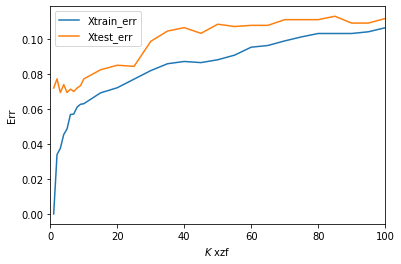

In [123]:
import matplotlib.pyplot as plt
x = np.arange(10)

plt.plot([i for i in ks], k_err_train)
plt.plot([i for i in ks], k_err_test)
plt.xlim(0,100)
plt.legend(['Xtrain_err', 'Xtest_err'], loc='upper left')
plt.xlabel('$K$ xzf')
plt.ylabel('Err')
plt.show()

## What do you observe about the training and test errors as K change?
As $K$ increases, the training and test error are both tend to increase.
There is a weak overfitting phenomenon  from k=1 to k=4.
k from 1 to 4, the overfitting become weaken. Therefore, test error decreases and train error inrease from k=1 

### Training and testing error rates for K = 1, 10 and 100.


In [124]:
print("Training error rates:")
print("\t K=1  ",k_err_train[0])
print("\t K=10 ",k_err_train[9])
print("\t K=100",k_err_train[-1])
print("Testing error rates:")
print("\t K=1  ",k_err_test[0])
print("\t K=10 ",k_err_test[9])
print("\t K=100",k_err_test[-1])

Training error rates:
	 K=1   0.00032626427406201586
	 K=10  0.06329526916802608
	 K=100 0.10668841761827075
Testing error rates:
	 K=1   0.072265625
	 K=10  0.07747395833333337
	 K=100 0.11197916666666663


**Preprocessing the data with log help to imporve accuracy hugely**

I dont know why, beacause log is just monotonic function.

Maybe it increase the difference of features.(from 0-100 to -inf-some value)！